# Making a injection vs structure projection matrix

Use SDK cache/functions to retreive metadata about the experiments

In [16]:
from allensdk.core.mouse_connectivity_cache import MouseConnectivityCache

# !! update this path so that it points to your external hard drive !!
mcc = MouseConnectivityCache(manifest_file='D:/connectivity/manifest.json')

# get metadata for all the experiments
all_experiments = mcc.get_experiments(dataframe=True)
print "There are %d experiments in the cache" % len(all_experiments)

There are 2173 experiments in the cache


Get ontology information

In [17]:
ontology = mcc.get_ontology()

# Experiment Filtering
Reduce the list of experiment to what you want to do your analysis

In [95]:
# EXAMPLE: Find all experiments that is wild and Rbp4-Cre_KL100 and injection within VIS or PTLp

include_lines = ['Rbp4-Cre_KL100','']
include_parent_structures = ['VIS','PTLp']
include_structures_id = ontology.get_descendant_ids(*ontology[include_parent_structures].id.values)

#
# NOTE: 
#
# (1) the werid input for get_descendant_ids is due to it wanting structures as independent input
# arguments - this is difficult to use!
#      ontology.get_descendant_ids(669,22)  - this works
#      ontology.get_descendant_ids([669,22]) - does not work
#
# (2) get_descendant_ids does not return itself - it should!
#

# some structure unionizes files on my disk are corrupt
exclude_experiments = [113887162]

experiment_mask = (
    all_experiments['transgenic-line'].isin(include_lines) &
    all_experiments['structure-id'].isin(include_structures_id) & 
    ~all_experiments['id'].isin(exclude_experiments)
    )

filtered_experiments = all_experiments[experiment_mask]

# reduce the number of experiments for this example
filtered_experiments = filtered_experiments[0:20]

print "There are %d experiments in my filtered experiment list" % len(filtered_experiments)

There are 20 experiments in my filtered experiment list


## Structure Filtering
Create the list of structures for which you want to report either injection or projection information

In [96]:
# EXAMPLE: Use the SDK to fetch the coarse 12 structural brain division

from allensdk.api.queries.ontologies_api import OntologiesApi

summary_structures = OntologiesApi().get_structures(structure_set_names='Mouse - Coarse')
summary_structure_ids = [ s['id'] for s in summary_structures ]

# order the structures by ontology graph order
filtered_structures = ontology[summary_structure_ids].sort('graph_order')
print "There are %d structures in my filtered structure list" % len(filtered_structures)

There are 12 structures in my filtered structure list


# Use helper function to make matrix

In [97]:
import connectivity_helper as chelp

In [98]:
test = chelp.generate_matrix( mcc, filtered_experiments, filtered_structures, [2,1],
                            is_injection=False, parameter='normalized_projection_volume')

In [99]:
test['matrix'].shape

(20L, 24L)

In [100]:
test['columns']

,hemisphere_id,label,structure_id
0,2,Isocortex-R,315
1,2,OLF-R,698
2,2,HPF-R,1089
3,2,CTXsp-R,703
4,2,STR-R,477
5,2,PAL-R,803
6,2,TH-R,549
7,2,HY-R,1097
8,2,MB-R,313
9,2,P-R,771


In [101]:
test['matrix'][0:5,0:5]

array([[  3.37778000e+01,   1.11757000e-01,   2.34832000e+00,
          6.88516000e-01,   5.76878000e+00],
       [  6.92477000e+00,   2.13456000e-02,   1.08492000e+00,
          1.58501000e-01,   1.14610000e+00],
       [  4.09363000e+00,   3.78954000e-03,   2.61788000e-01,
          2.73140000e-02,   5.12929000e-01],
       [  2.20761000e+01,   8.98406000e-02,   7.09879000e-01,
          4.83802000e-02,   4.77634000e+00],
       [  3.12095000e+01,   6.88178000e-02,   9.49777000e-01,
          3.90887000e-02,   5.36375000e+00]])

Show matrix as heatmap using Lightning!
(pip install lightning-python)


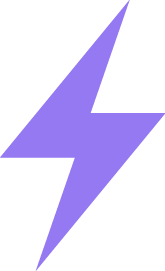

Running local mode, some functionality limited.



In [102]:
from lightning import Lightning
import numpy as np
lgn = Lightning(ipython=True, local=True)
lgn.set_size('full')

In [103]:
# label rows by primary injection site acronym
row_labels = filtered_experiments['structure-abbrev']

# label columns by structure-hemisphere
column_labels = test['columns']['label'].values

In [104]:
# fill in the nan by zero for visualization
import numpy as np
matrix = test['matrix'].copy()
matrix = np.log10(matrix+1)
lgn.matrix(matrix, row_labels=row_labels, column_labels=column_labels)